In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

Goal: Predict the political polarity of Massachusetts towns (ie wicked blue, medium blue, light blue, or red) and discover most important features. ie predict '2020_label'

Data set: attached town_data.csv containing 75 facts about 350 Massachusetts towns and cities

### Exploratory Data Analysis

In [2]:
csv_path = os.path.join('town_data.csv')
town_data = pd.read_csv(csv_path)

Lets get an idea of what this data set contains

In [3]:
display(town_data.head())
print(town_data.shape)

,town,accountants_per_10000_residents_2013,apartments_condos_multis_per_residential_parcels_2011,architects_per_10000_2013,assessed_home_value_changes_2009-2013,barbers_per_10000_residents_2013,births_per_1000_residents_2010,boaters_per_10000_residents_2012,burglaries_per_10000_residents_2011,cars_motorcycles_&_trucks_average_age_2012,...,tax_bills_for_single-family_homes_2013,taxable_property_by_percent_2012,teacher_salaries_by_average_2011,teachers_percent_under_40_years_old_2011-2012,trucks_per_1000_residents_2012,veterinarians_per_10000_2013,violent_crimes_per_10000_residents_2012,voters_as_a_percent_of_population_2012,voters_change_in_registrations_between_1982-2012,2020_label
0,Abington,29.4,0.219,3.8,-0.149,8.1,12.1,137.6,63.5,9.9,...,4756.0,92.9,73887.0,0.32,354,1.3,25.3,10902,0.51,light blue
1,Acton,36.0,0.329,10.5,-0.004,1.8,8.2,69.8,10.4,8.5,...,9650.0,93.7,75741.0,0.31,280,6.4,10.3,14398,0.34,wicked blue
2,Acushnet,7.8,0.050,0.0,-0.188,7.8,8.0,287.3,41.7,10.9,...,3380.0,95.1,57227.0,0.43,379,1.9,12.5,7478,0.44,red
3,Adams,5.9,0.209,1.2,-0.051,11.8,10.3,212.1,77.1,10.0,...,2453.0,88.0,NaN,NaN,366,0.0,48.2,5980,-0.03,medium blue
4,Agawam,15.1,0.214,1.4,-0.107,8.1,9.6,246.1,19.3,9.7,...,3245.0,88.1,60647.0,0.36,328,2.1,11.8,21365,0.63,red


(350, 75)


In [4]:
display(town_data.info()) # Check that kind of features we have 
list_col = [col  for col in town_data.columns if town_data[col].dtype == 'object'] # Lets look at our categorical data and label
print(list_col)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 75 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   town                                                              350 non-null    object 
 1   accountants_per_10000_residents_2013                              350 non-null    float64
 2   apartments_condos_multis_per_residential_parcels_2011             349 non-null    float64
 3   architects_per_10000_2013                                         350 non-null    float64
 4   assessed_home_value_changes_2009-2013                             335 non-null    float64
 5   barbers_per_10000_residents_2013                                  350 non-null    float64
 6   births_per_1000_residents_2010                                    350 non-null    float64
 7   boaters_per_10000_residents_2012   

None

['town', '2020_label']


Looks like town and 2020_label are our only categorical features 

Inspect label distribution

In [5]:
print(town_data['2020_label'].value_counts())

light blue     107
medium blue    103
red             84
wicked blue     56
Name: 2020_label, dtype: int64


Lets check our data set for missing values

In [6]:
na_town_feature_series = town_data.isna().sum().sort_values(ascending=False)
display(na_town_feature_series)


teacher_salaries_by_average_2011                 119
pupils_per_cost_average_by_district_2011-2012    114
minority_students_per_district_2012-2013         113
school_district_growth_09-13                     113
class_size_in_school_district_2011-2012          113
                                                ... 
inmates_in_state_prison_per_1000_residents         0
median_age_2011                                    0
miles_driven_daily_per_household_05-07             0
motorcycles_change_in_ownership_2000-2012          0
2020_label                                         0
Length: 75, dtype: int64

There appears to be a few columns with a lot of missing data. Lets investigate further

In [7]:
na_town_feature_series[na_town_feature_series > .15*len(town_data)]


teacher_salaries_by_average_2011                 119
pupils_per_cost_average_by_district_2011-2012    114
minority_students_per_district_2012-2013         113
school_district_growth_09-13                     113
class_size_in_school_district_2011-2012          113
teachers_percent_under_40_years_old_2011-2012    110
burglaries_per_10000_residents_2011               87
property_crimes_per_10000_residents_2012          83
violent_crimes_per_10000_residents_2012           83
dentists_per_10000_2013                           76
police_employees_per_10000_residents_2011         54
dtype: int64

Here we can see these categories are missing for more than 15% of the data. Its worth noting that none of these features are missing for more than 50% of the data so they will not be dropped. 

Lets see how we should handle these missing values by taking a look at their distributions and statistics

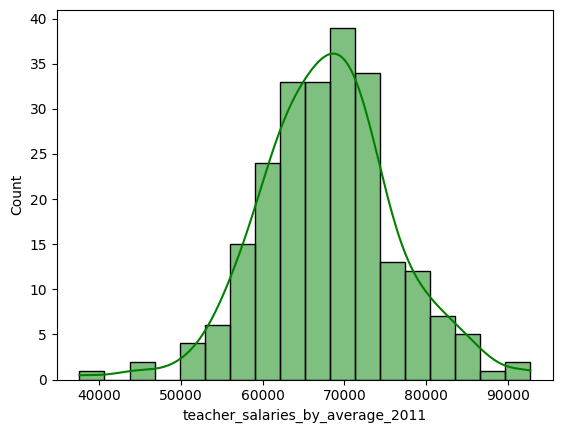

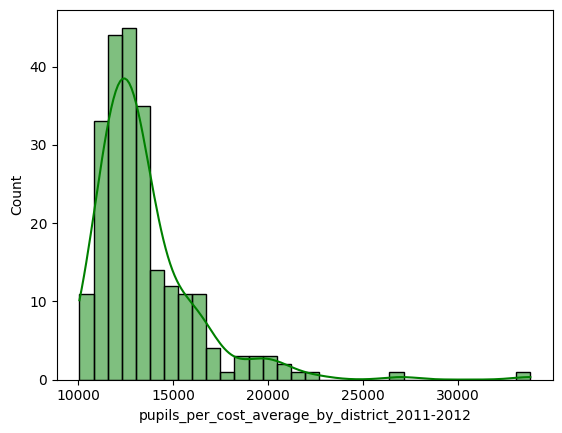

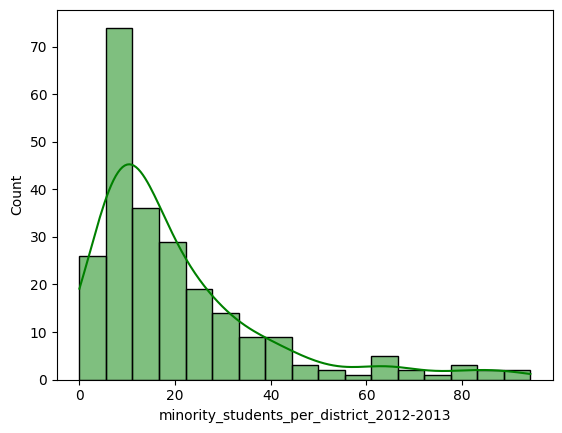

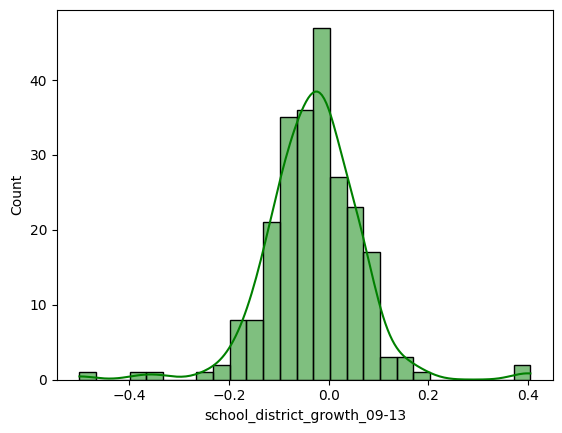

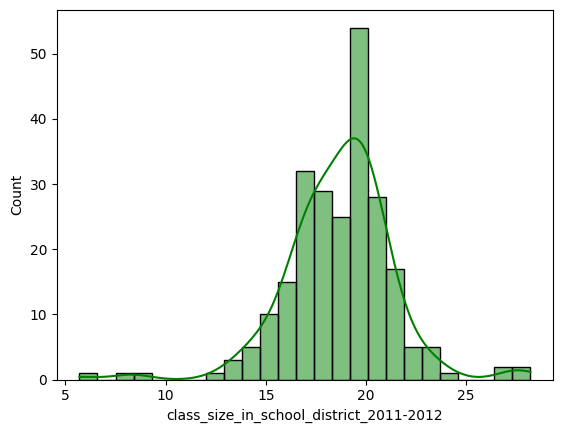

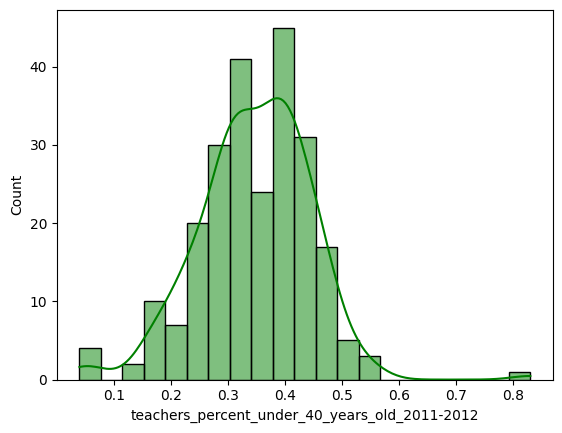

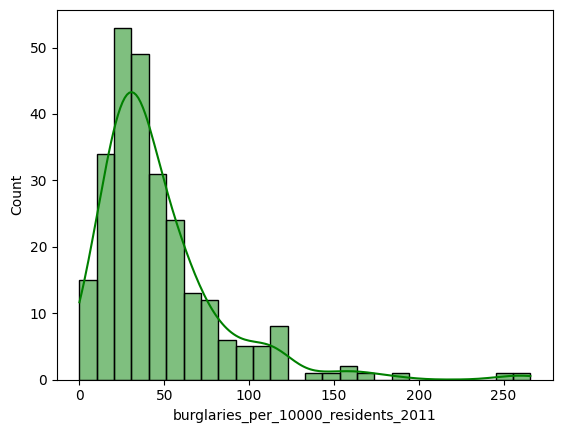

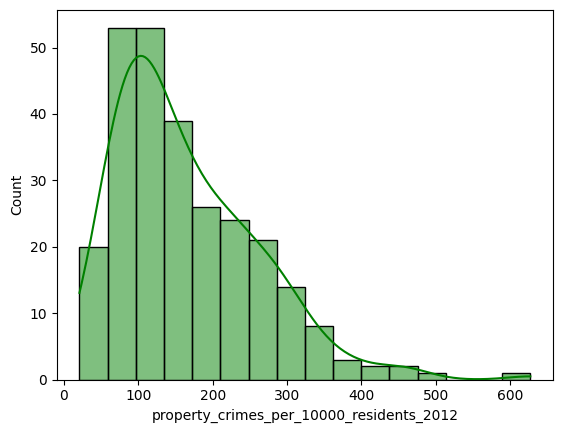

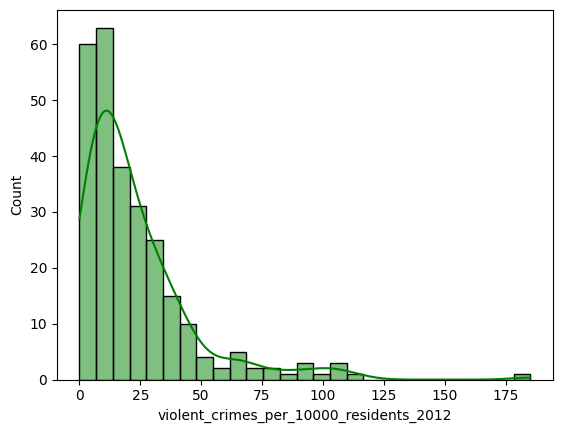

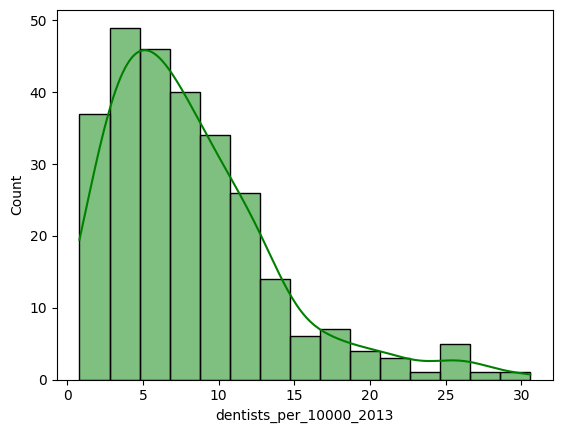

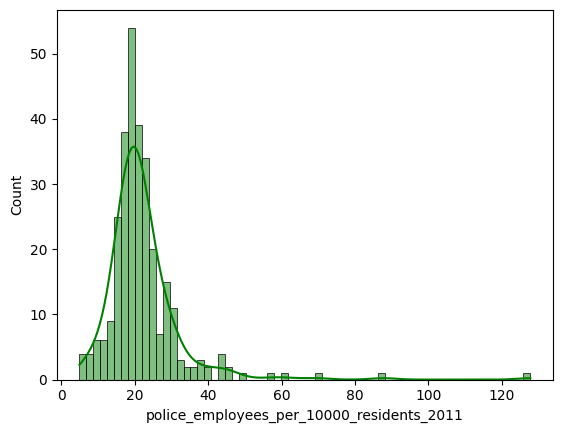

,teacher_salaries_by_average_2011,pupils_per_cost_average_by_district_2011-2012,minority_students_per_district_2012-2013,school_district_growth_09-13,class_size_in_school_district_2011-2012,teachers_percent_under_40_years_old_2011-2012,burglaries_per_10000_residents_2011,property_crimes_per_10000_residents_2012,violent_crimes_per_10000_residents_2012,dentists_per_10000_2013,police_employees_per_10000_residents_2011
count,231.000000,236.000000,237.000000,237.000000,237.000000,240.000000,263.000000,267.000000,267.000000,274.000000,296.000000
mean,67912.952381,13502.961864,20.400422,-0.029987,18.678059,0.346958,46.512167,165.142322,22.814981,8.154380,22.203378
std,8163.202881,2783.891986,18.493241,0.094813,2.697838,0.097998,36.826002,95.855401,23.750745,5.562301,10.865095
min,37580.000000,10064.000000,0.000000,-0.500000,5.700000,0.040000,0.000000,21.000000,0.000000,0.800000,4.900000
25%,62619.500000,11904.000000,8.700000,-0.083000,17.200000,0.290000,24.700000,94.000000,7.600000,4.125000,17.575000
50%,68077.000000,12784.500000,14.000000,-0.028000,18.900000,0.350000,36.000000,142.000000,15.400000,6.900000,20.150000
75%,72534.000000,14197.250000,26.300000,0.023000,20.100000,0.410000,58.350000,222.500000,29.800000,10.700000,23.900000
max,92765.000000,33811.000000,94.300000,0.405000,28.200000,0.830000,265.800000,627.000000,185.200000,30.600000,127.800000


In [8]:
na_label_list = na_town_feature_series[na_town_feature_series > .15*len(town_data)].index.tolist()

plot = plt.plot(figsize=(15, 15))
for label in na_label_list:
   
    sns.histplot(data=town_data,x=label,kde=True,color='g')

    plt.show()

town_data[na_label_list].describe()


From the table and plots above, we can see that pupils_per_cost_average_by_district_2011-2012, minority_students_per_district_2012-2013, property_crimes_per_10000_residents_2012, violent_crimes_per_10000_residents_2012, dentists_per_10000_2013, police_employees_per_10000_residents_2011 are heavily skewed. So for these features, we will impute the median values. The remaining columns can be imputed using the mean

In [9]:
town_labels = town_data["2020_label"]
town_features = town_data.drop("2020_label", axis=1)

### Data Preparation and Cleaning

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(town_features, town_labels, test_size=0.2, random_state=42)



# Town names are not useful for training, but will be needed later
X_train_towns = X_train["town"]
X_train = X_train.drop("town", axis=1)

X_test_towns = X_test["town"]
X_test = X_test.drop("town", axis=1)
features = list(X_train.columns)


# Separate median and mean features
median_features = ["pupils_per_cost_average_by_district_2011-2012", "minority_students_per_district_2012-2013", "property_crimes_per_10000_residents_2012", "violent_crimes_per_10000_residents_2012", "dentists_per_10000_2013", "police_employees_per_10000_residents_2011"]
mean_features = list(set(features) - set(median_features))


# Create median and mean pipelines with imputer and scaler
median_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy="median")),
    ("std_scale", StandardScaler())
])
mean_pipeline = Pipeline([
     ('mean_imputer', SimpleImputer(strategy="mean")),
    ("std_scale", StandardScaler())

])
# We'll need an LabelEncoder to convert labels from strings to numbers and vice versa
label_encoder = LabelEncoder()

# Apply pipelines to specified columns
column_transform = ColumnTransformer([
    ("median_pipeline", median_pipeline, median_features),
    ('mean_pipeline', mean_pipeline, mean_features)
])


y_train_tr = label_encoder.fit_transform(y_train)
y_test_tr = label_encoder.transform(y_test)


X_train_tr = column_transform.fit_transform(X_train) # transformed town data
X_test_tr = column_transform.transform(X_test)

X_train_DF = pd.DataFrame(data=X_train_tr, index=[X_train_towns], columns=[X_train.columns])
X_train_tr = X_train_DF
display(X_train_tr)


,accountants_per_10000_residents_2013,apartments_condos_multis_per_residential_parcels_2011,architects_per_10000_2013,assessed_home_value_changes_2009-2013,barbers_per_10000_residents_2013,births_per_1000_residents_2010,boaters_per_10000_residents_2012,burglaries_per_10000_residents_2011,cars_motorcycles_&_trucks_average_age_2012,cars_per_1000_residents_2012,...,tax_bills_for_single-family_homes_2012,tax_bills_for_single-family_homes_2013,taxable_property_by_percent_2012,teacher_salaries_by_average_2011,teachers_percent_under_40_years_old_2011-2012,trucks_per_1000_residents_2012,veterinarians_per_10000_2013,violent_crimes_per_10000_residents_2012,voters_as_a_percent_of_population_2012,voters_change_in_registrations_between_1982-2012
town,,,,,,,,,,,,,,,,,,,,,
Pelham,0.646411,0.445405,-1.248891,-1.080284,-0.197046,-1.820481,-0.973926,1.261936,-0.791036,-0.062155,...,-1.637605,0.437856,-0.614115,-0.674312,0.881795,-0.720378,-0.846834,-0.092111,-0.477648,-0.276780
Dover,2.419538,-0.040037,-0.931236,-0.802231,2.821339,1.150093,-0.541983,0.935142,-0.424092,6.333752,...,-0.705357,-0.343380,-1.950147,0.027472,3.396019,-0.713253,-0.846834,-1.013216,2.062302,-0.583804
Egremont,-0.207497,-0.285995,-0.112663,0.199808,-0.197046,4.631029,-0.973926,-1.149584,-0.295662,-0.551444,...,-1.114637,2.183751,0.853870,-0.674312,-0.714191,-0.948374,0.092229,0.000845,-1.572455,-0.424404
Attleboro,-0.862562,0.529548,-0.210403,0.609018,-0.689843,-0.237048,0.118636,0.360434,-1.268063,-0.372708,...,0.780176,-0.465661,0.227090,0.529307,-0.639857,0.519354,0.092229,-0.244220,0.135443,-0.578757
Colrain,-0.207497,-0.285995,-0.210403,-0.261864,-0.197046,-0.171617,-0.973926,0.968948,-1.047897,-0.424361,...,-0.000487,0.634864,0.243584,-0.674312,-0.821319,-0.670503,-0.142536,1.133213,-0.302479,-0.197921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Danvers,-0.188145,-0.428391,1.524483,0.047666,0.973348,0.050849,0.957114,-0.935477,1.006989,-0.099050,...,0.029830,-0.411314,0.688928,1.117394,-0.397180,0.654727,-0.259919,-0.379428,-0.433856,-0.122637
Gloucester,0.303880,-0.493117,-0.161533,-0.597626,-0.525577,-0.001496,0.245678,-1.724292,1.612447,-0.203325,...,-0.205127,-0.472454,1.282720,-0.250889,-0.919701,0.968222,0.444378,-0.472383,-1.090740,1.236680
Shutesbury,1.027645,0.199447,-0.210403,-0.261864,-0.197046,-0.171617,-0.948517,0.912604,-0.075495,-0.557854,...,-0.947893,0.179709,-0.267736,-0.674312,0.726569,-0.848626,-0.846834,-0.489284,-0.171103,0.325912


In [33]:
X_train_tr.isna().sum().sort_values() # verify imputation was performed correctly

accountants_per_10000_residents_2013                0
property_crimes_per_10000_residents_2012            0
population_change_2010-2011                         0
population_change_1950-2010                         0
police_spending_as_a_percent_2012                   0
                                                   ..
females_percent_in_community_2010                   0
expenditures_per_resident_2012                      0
electricians_per_1000_residents_2013                0
income_average_per_resident_2010                    0
voters_change_in_registrations_between_1982-2012    0
Length: 73, dtype: int64

## Model Exploration: Decision Tree, Random Forest, KNN

#### Decision Tree Classifier

In [34]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import randint

basic_tree = DecisionTreeClassifier(random_state=42)

param_dist_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [3, 5, 10, 15],
    'max_features': [3, 5, 10]
}

basic_tree_clf = GridSearchCV(basic_tree, param_dist_tree, cv=3)


In [35]:
basic_tree_clf.fit(X_train_tr, y_train_tr)
print(basic_tree_clf.best_estimator_)
print(basic_tree_clf.best_params_)
print(basic_tree_clf.best_score_)

DecisionTreeClassifier(max_depth=5, max_features=10, min_samples_leaf=3,
                       random_state=42)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 3}
0.5181499275528102


#### Random Forest

In [36]:

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)

param_grid_forest = {
    'n_estimators': [50, 75, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 25],
    'bootstrap': [True, False]
    
}

forest_clf = GridSearchCV(forest, param_grid_forest, cv=3, n_jobs=-1)

In [37]:
forest_clf.fit(X_train_tr, y_train_tr)

print(forest_clf.best_estimator_)
print(forest_clf.best_params_)
print(forest_clf.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=10, random_state=42)
{'bootstrap': False, 'max_depth': 10, 'n_estimators': 100}
0.6823381377259209


#### KNN

In [38]:

from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

param_grid_KNN = {
    'n_neighbors':[2, 3, 4, 5, 10]
}

KNN_clf = GridSearchCV(KNN, param_grid_KNN, cv=3) 


In [39]:
KNN_clf.fit(X_train_tr, y_train_tr)
print(KNN_clf.best_estimator_)
print(KNN_clf.best_params_)
print(KNN_clf.best_score_)


KNeighborsClassifier()
{'n_neighbors': 5}
0.5320674140166247


#### XGBoost

In [42]:

XGB = XGBClassifier(objective = 'multi:softprob', random_state=42)
XGB_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 10, 15]
        }
xgb_clf = GridSearchCV(estimator=XGB, param_grid=XGB_params, cv = 3)

xgb_clf.fit(X_train_tr, y_train_tr)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None, ...),
             param_grid={'gamma': [0.5, 1, 1.5, 2, 5],
                         'max_depth': [3, 5, 10, 15],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]})

## Evaluation on Test Set

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels_inverse = label_encoder.inverse_transform(basic_tree_clf.classes_)


#### Tree test set evaluation

Tree final performance
Accuracy: 0.5571428571428572
F1 Score: 0.5552380952380952


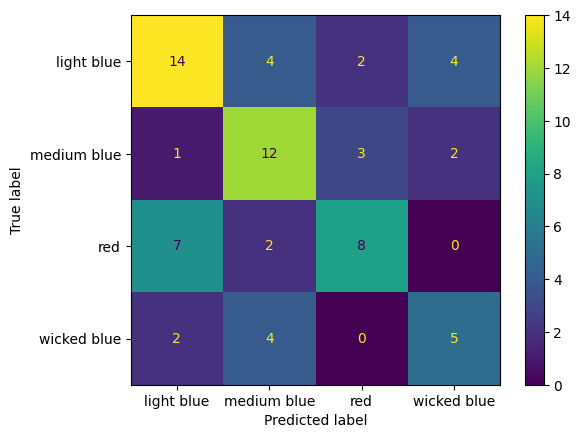

In [44]:

y_test_tree = basic_tree_clf.predict(X_test_tr)

tree_acc =  accuracy_score(y_test_tr, y_test_tree)
tree_f1 = f1_score(y_test_tr, y_test_tree, average='weighted')

print("Tree final performance")
print(f"Accuracy: {tree_acc}")
print(f"F1 Score: {tree_f1}")


matrix_tree = confusion_matrix(y_test_tr, y_test_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=matrix_tree, display_labels=labels_inverse)
disp_tree.plot()



#### Forest test set evaluation

Forest final performance
Accuracy: 0.7571428571428571
F1 Score: 0.7559349593495934


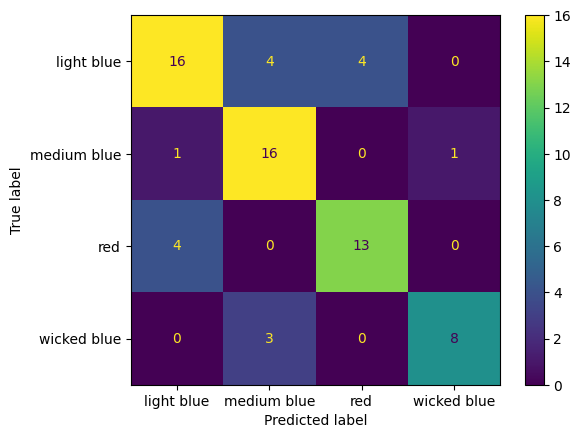

In [45]:

y_test_forest = forest_clf.predict(X_test_tr)

forest_acc =  accuracy_score(y_test_tr, y_test_forest)
forest_f1 = f1_score(y_test_tr, y_test_forest, average='weighted')

print("Forest final performance")
print(f"Accuracy: {forest_acc}")
print(f"F1 Score: {forest_f1}")


matrix_forest = confusion_matrix(y_test_tr, y_test_forest)
disp_forest = ConfusionMatrixDisplay(confusion_matrix=matrix_forest, display_labels=labels_inverse)
disp_forest.plot()


#### KNN test set evaluation

K Nearest Neighbors final performance
Accuracy: 0.6142857142857143
F1 Score: 0.6173818917811027


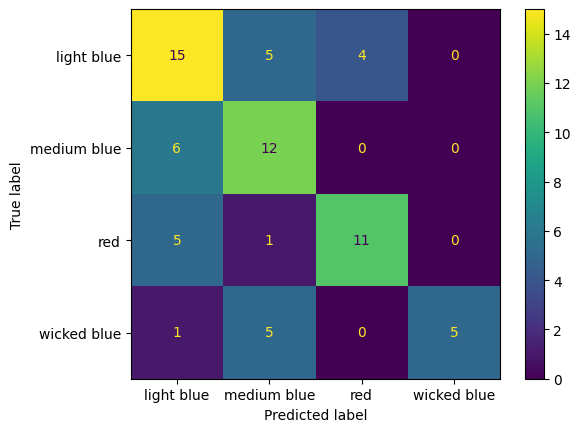

In [46]:

y_test_KNN = KNN_clf.predict(X_test_tr)

KNN_acc =  accuracy_score(y_test_tr, y_test_KNN)
KNN_f1 = f1_score(y_test_tr, y_test_KNN, average='weighted')

print("K Nearest Neighbors final performance")
print(f"Accuracy: {KNN_acc}")
print(f"F1 Score: {KNN_f1}")


matrix_KNN = confusion_matrix(y_test_tr, y_test_KNN)
disp_KNN = ConfusionMatrixDisplay(confusion_matrix=matrix_KNN, display_labels=labels_inverse)
disp_KNN.plot()



#### XGBoost test set evaluation

XGBoost final performance
Accuracy: 0.6857142857142857
F1 Score: 0.6806811913954771


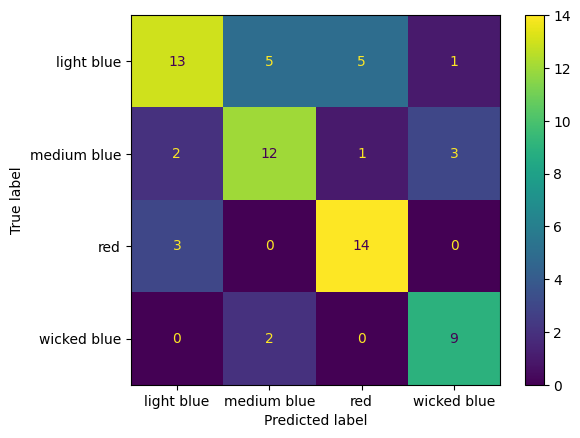

In [47]:

y_test_xgb = xgb_clf.predict(X_test_tr)

xgb_acc =  accuracy_score(y_test_tr, y_test_xgb)
xgb_f1 = f1_score(y_test_tr, y_test_xgb, average='weighted')

print("XGBoost final performance")
print(f"Accuracy: {xgb_acc}")
print(f"F1 Score: {xgb_f1}")

matrix_XGB = confusion_matrix(y_test_tr, y_test_xgb)
disp_XGB = ConfusionMatrixDisplay(confusion_matrix=matrix_XGB, display_labels=labels_inverse)
disp_XGB.plot()


## Results

Lets take a look at the important features from the best performing model

In [48]:

importance_data = {'Feature': X_train.columns,'Importance Score':forest_clf.best_estimator_.feature_importances_}
features_importances = pd.DataFrame(data=importance_data)
print("Most important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = False)[:10])
print("Least important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = True)[:10])



Most important Features:


,Feature,Importance Score
46,police_costs_per_resident_2013,0.053924
63,tax_bills_for_single-family_homes_2012,0.050567
59,snowmobiles_per_10000_residents_2012,0.036250
36,income_change_per_resident_2007-2010,0.034373
11,condos_as_perc_of_parcels_2012,0.031898
70,violent_crimes_per_10000_residents_2012,0.031457
71,voters_as_a_percent_of_population_2012,0.028224
31,households_average_size_2010,0.027215
58,single-person_households_percent_65_and_older,0.026211
20,expenditures_per_resident_2012,0.022971


Least important Features:


,Feature,Importance Score
32,households_one-person_2010,0.004601
37,inmates_in_state_prison_per_1000_residents,0.005408
69,veterinarians_per_10000_2013,0.005766
47,police_employees_per_10000_residents_2011,0.005905
2,architects_per_10000_2013,0.006366
5,births_per_1000_residents_2010,0.007094
15,dentists_per_10000_2013,0.007390
50,population_change_2010-2011,0.007465
16,doctors_per_10000_residents_2013,0.007500
27,historic_places_per_10000_2013,0.007501


# Generalization to Democrat vs Republican Binary


First, lets prep this data

In [49]:
import numpy as np

# First we need figure out the mapping of our labels 
classes_as_str = label_encoder.classes_
classes_as_num = label_encoder.transform(label_encoder.classes_)
mapping = dict(zip(classes_as_str, classes_as_num))
print(mapping)

{'light blue': 0, 'medium blue': 1, 'red': 2, 'wicked blue': 3}


In [50]:
# Now, we know red is 2 and the remainder are blue
y_train_binary = np.where(y_train_tr == 2, "red", "blue") # Convert back to strings so we can use a new encoder
y_test_binary = np.where(y_test_tr == 2, "red", "blue") 

bin_encoder = LabelEncoder()
y_train_binary_tr = bin_encoder.fit_transform(y_train_binary)
y_test_binary_tr = bin_encoder.transform(y_test_binary)

### Binary Classification Training 

#### Random Forest Binary Classification

In [51]:


forest_binary = RandomForestClassifier(random_state=42)

param_grid_forest = {
    'n_estimators': [50, 75, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 25],
    'bootstrap': [True, False]
    
}

forest_binary_clf = GridSearchCV(forest_binary, param_grid_forest, cv=5, n_jobs=-1)
forest_binary_clf.fit(X_train_tr, y_train_binary_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 25],
                         'n_estimators': [50, 75, 100, 150, 200, 250]})

#### XGBoost Binary Classification

In [28]:

xgb_binary_clf = XGBClassifier()

xgb_binary_clf.fit(X_train_tr, y_train_binary_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Binary Classification Model Evaluation

#### Forest Binary test set evaluation

Forest Binary final performance
Accuracy: 0.9285714285714286
F1 Score: 0.8387096774193549


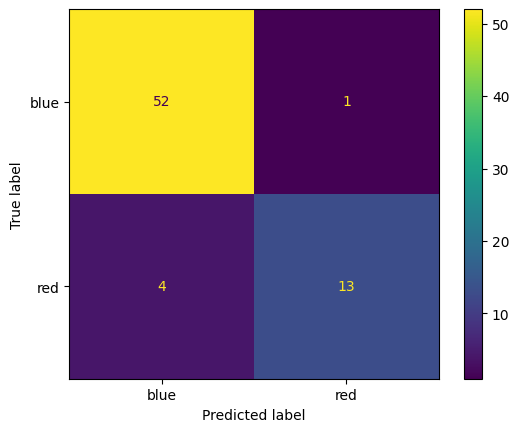

In [29]:

y_test_forest_binary = forest_binary_clf.predict(X_test_tr)

forest_acc =  accuracy_score(y_test_binary_tr, y_test_forest_binary)
forest_f1 = f1_score(y_test_binary_tr, y_test_forest_binary, average ='binary')

print("Forest Binary final performance")
print(f"Accuracy: {forest_acc}")
print(f"F1 Score: {forest_f1}")

labels_inverse_bin = bin_encoder.inverse_transform(forest_binary_clf.classes_)
matrix_forest_bin = confusion_matrix(y_test_binary_tr, y_test_forest_binary)
disp_forest_bin = ConfusionMatrixDisplay(confusion_matrix=matrix_forest_bin, display_labels=labels_inverse_bin)
disp_forest_bin.plot()

#### XGBoost test set evaluation

XGBoost Binary final performance
Accuracy: 0.9142857142857143
F1 Score: 0.8235294117647058


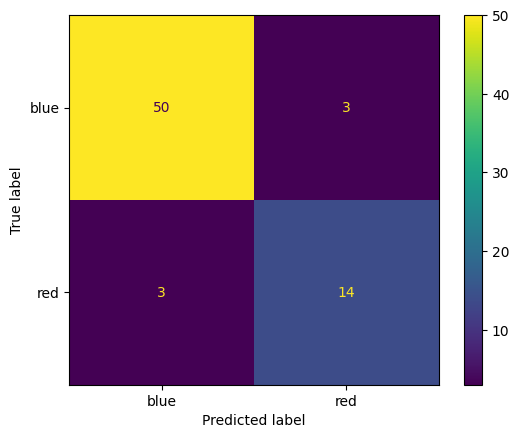

In [30]:

y_test_xgb_binary = xgb_binary_clf.predict(X_test_tr)

xgb_acc =  accuracy_score(y_test_binary_tr, y_test_xgb_binary)
xgb_f1 = f1_score(y_test_binary_tr, y_test_xgb_binary, average='binary')

print("XGBoost Binary final performance")
print(f"Accuracy: {xgb_acc}")
print(f"F1 Score: {xgb_f1}")


matrix_XBG_bin = confusion_matrix(y_test_binary_tr, y_test_xgb_binary)
disp_XGB_bin = ConfusionMatrixDisplay(confusion_matrix=matrix_XBG_bin, display_labels=labels_inverse_bin)
disp_XGB_bin.plot()

#### Feature Examination for Binary Classification

In [53]:



importance_data = {'Feature': X_train.columns,'Importance Score':forest_binary_clf.best_estimator_.feature_importances_}
features_importances = pd.DataFrame(data= importance_data)
print("Most important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = False)[:10])
print("Least important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = True)[:10])


Most important Features:


,Feature,Importance Score
46,police_costs_per_resident_2013,0.072252
63,tax_bills_for_single-family_homes_2012,0.055261
58,single-person_households_percent_65_and_older,0.045784
71,voters_as_a_percent_of_population_2012,0.042158
59,snowmobiles_per_10000_residents_2012,0.040799
70,violent_crimes_per_10000_residents_2012,0.039183
21,females_percent_in_community_2010,0.027084
4,barbers_per_10000_residents_2013,0.023248
72,voters_change_in_registrations_between_1982-2012,0.022796
36,income_change_per_resident_2007-2010,0.022067


Least important Features:


,Feature,Importance Score
52,property_tax_change_09-13,0.002314
62,tax-exempt_property_2012,0.003018
34,in_home_since_1969_or_earlier,0.003185
69,veterinarians_per_10000_2013,0.003240
54,real_estate_professionals_per_1000_residents_2013,0.003770
3,assessed_home_value_changes_2009-2013,0.004066
0,accountants_per_10000_residents_2013,0.004069
51,property_crimes_per_10000_residents_2012,0.004296
44,motorcycles_per_1000_2012,0.004405
11,condos_as_perc_of_parcels_2012,0.005337
